In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
import numpy as np
import numexpr as ne
from datetime import datetime
import ipdb
# from scipy.ndimage import imread
%load_ext line_profiler
import import_ipynb
from mathfunk import *

In [2]:
class Hexgrid():
    '''Simulates a turbidity current using a CA. '''

    def __init__(self, Nx, Ny, ICstates=None, reposeAngle=np.deg2rad(0), dx=1, terrain=None):
        ################ Constants ######################
        self.g = 9.81  # Gravitational acceleration
        self.f = 0.04  # Darcy-Weisbach coeff
        self.a = 0.43  # Empirical coefficient
        self.rho_a = 1000  # ambient density
        self.rho_j = np.array([2650])  # List of current sediment densities
        self.D_sj = np.array([0.001])  # List of sediment-particle diameters
        self.Nj = 1  # Number of sediment types
        self.c_D = 0.003  # Bed drag coefficient
        self.v_sj = np.array([0.1])  # List of sediment-particle fall-velocities
        self.nu = 1.5182e-06  # Kinematic viscosity of water at 5 degrees celcius
        self.porosity = 0.3

        # Constants used in I_1:
        self.p_f = np.deg2rad(1)  # Height threshold friction angle
        self.p_adh = 1
        ############## Input variables ###################
        self.Nx = Nx
        self.Ny = Ny
        self.dx = dx
        self.reposeAngle = reposeAngle

        ################     Grid       ###################
        self.X = np.zeros((Ny, Nx, 2))  # X[:,:,0] = X coords, X[:,:,1] = Y coords
        for j in range(Ny):
            self.X[j, :, 0] = j * dx / 2 + np.arange(Nx) * dx
            self.X[j, :, 1] = -np.ones(Nx) * dx * np.sqrt(3) / 2 * j

        ################# Cell substate storage ####################
        #         self.Q_a   = np.zeros((self.Ny,self.Nx)) # Cell altitude (bathymetry at t = 0)
        self.Q_th = np.zeros((self.Ny, self.Nx))  # Turbidity current thickness
        self.Q_v = np.zeros((self.Ny, self.Nx))  # Turbidity current speed (scalar)
        self.Q_cj = np.zeros((self.Ny, self.Nx, self.Nj))  # jth current sediment volume concentration
        self.Q_cbj = np.zeros((self.Ny, self.Nx, self.Nj))  # jth bed sediment volume fraction
        self.Q_d = np.ones((self.Ny, self.Nx)) * np.inf  # Thickness of soft sediment
        self.Q_d[1:-1, 1:-1] = 0
        self.Q_a = self.Q_d.copy()  # Bathymetry legges til Q_a i self.setBathymetry(terrain)
        self.Q_o = np.zeros((self.Ny, self.Nx, 6))  # Density current outflow

        ################### Set Initial conditions #####################
        if ICstates is not None: self.setIC(ICstates)
        self.CellArea = calc_hexagon_area(dx)
        self.setBathymetry(terrain)
        self.diff = np.zeros((self.Ny - 2, self.Ny - 2, 6))
        self.seaBedDiff = np.zeros((self.Ny - 2, self.Nx - 2, 6))
        self.calc_bathymetryDiff()

        #         self.totalheight = self.Q_d + self.Q_a

        self.defineNeighbors()

        ################################################################
        ##########################  Methods ############################
        ################################################################
    def setIC(self,ICstates):
        self.Q_th  = ICstates[0]
        self.Q_v   = ICstates[1]
        self.Q_cj  = ICstates[2]
        self.Q_cbj = ICstates[3]
        self.Q_d   = ICstates[4]
        self.Q_o   = ICstates[5]
        self.Q_a = self.Q_d.copy()

    def defineNeighbors(self):
        '''
        This function defines indices that can be used to reference the neighbors of a cell.\
        Use: self.Q_v[self.NEIGHBOR[0]] = NW neighbors' value of Q_v
        '''
        self.NEIGHBOR = []
        self.NEIGHBOR.append(np.ix_(np.arange(0, self.Ny - 2), np.arange(1, self.Nx - 1)))
        self.NEIGHBOR.append(np.ix_(np.arange(0, self.Ny - 2), np.arange(2, self.Nx)))
        self.NEIGHBOR.append(np.ix_(np.arange(1, self.Ny - 1), np.arange(2, self.Nx)))
        self.NEIGHBOR.append(np.ix_(np.arange(2, self.Ny), np.arange(1, self.Nx - 1)))
        self.NEIGHBOR.append(np.ix_(np.arange(2, self.Ny), np.arange(0, self.Nx - 2)))
        self.NEIGHBOR.append(np.ix_(np.arange(1, self.Ny - 1), np.arange(0, self.Nx - 2)))

    def time_step(self):
        #         g_prime = self.calc_g_prime()
        self.dt = self.calc_dt()  # Works as long as all ICs are given
        #         print("dt = ", self.dt)
        # The order comes from the article

        #         print("self.Q_th =\n", self.Q_th )
        #         print("self.Q_v  =\n", self.Q_v  )
        #         print("self.Q_cj =\n", self.Q_cj )
        #         print("self.Q_cbj=\n", self.Q_cbj)
        #         print("self.Q_d  =\n", self.Q_d  )
        #         print("self.Q_a  =\n", self.Q_a  )
        #         print("self.Q_o  =\n", self.Q_o  )
        self.T_1() # Water entrainment.
        self.T_2() # Erosion and deposition
        self.I_1() # Turbidity c. outflows
        self.I_2() # Update thickness and concentration
        self.I_3() # Update of turbidity flow velocity
        self.I_4() # Toppling rule

    #         print("After \n")
    #         print("self.Q_th =\n", self.Q_th )
    #         print("self.Q_v  =\n", self.Q_v  )
    #         print("self.Q_cj =\n", self.Q_cj )
    #         print("self.Q_cbj=\n", self.Q_cbj)
    #         print("self.Q_d  =\n", self.Q_d  )
    #         print("self.Q_a  =\n", self.Q_a  )
    #         print("self.Q_o  =\n", self.Q_o  )

    def T_1(self):  # Water entrainment. IN: Q_a,Q_th,Q_cj,Q_v. OUT: Q_vj,Q_th
        '''
        This function calculates the water entrainment.\
        Entrainment is the transport of fluid across an interface\
        between two bodies of fluid by a shear induced turbulent flux.\

        '''
        #         ipdb.set_trace()
        g_prime = calc_g_prime(self.Nj, self.Q_cj, self.rho_j, self.rho_a, g=self.g)
        #         print("g_prime = ", g_prime)
        with np.errstate(divide='ignore', invalid='ignore'):
            Ri = g_prime * self.Q_th / (self.Q_v ** 2) # Richardson number
        # Ri[Ri == 0] = np.inf
        E_wStar = np.nan_to_num(0.075 / np.sqrt(1 + 718 * Ri ** (2.4)))  # Dimensionless incorporation rate
        E_w = self.Q_v * E_wStar  # Rate of seawater incorporation
        nQ_th = self.Q_th + E_w * self.dt  # Update cell current thickness
        # nQ_th[np.isnan(nQ_th)] = 0
        #         print("T1: nQ_th.shape=", nQ_th.shape)
        with np.errstate(divide='ignore', invalid='ignore'):
            tempQ_cj = self.Q_cj * (self.Q_th / nQ_th)[:, :, np.newaxis]
        tempQ_cj[np.isnan(tempQ_cj)] = 0

        self.Q_cj = np.nan_to_num(tempQ_cj)
        #         print("T1: self.Q_cj.shape=",self.Q_cj.shape)

        self.Q_th = np.nan_to_num(nQ_th)

    def T_2(self):
        '''
        This function updates Q_a,Q_d,Q_cj and Q_cbj. According to erosion and deposition rules.\
        IN: Q_a,Q_th,Q_cj,Q_cbj,Q_v. OUT:
        '''
        # R_pj = numpy.ndarray(Nj)
        # f = numpy.ndarray(Nj)
        # kappa = double
        # Ustar = numpy.ndarray(Ny,Nx)
        # g_reduced = numpy.ndarray(Nj)
        # v_sjSTAR = numpy.ndarray(Nj)
        # D_sg = numpy.ndarray(Ny,Nx)
        # c_nbj = numpy.ndarray(Ny,Nx,Nj)
        # D_j = numpy.ndarray(Ny,Nx,Nj)
        # Z_mj = numpy.ndarray(Ny,Nx,Nj)
        # E_j = numpy.ndarray(Ny,Nx,Nj)

        R_pj = calc_Rpj(self.rho_j, self.rho_a, self.D_sj, self.nu, g=self.g)  # Assume rho = rho_ambient.
        #         print("R_pj=\n",R_pj)
        f = calc_fofR(R_pj)
        kappa = calc_kappa(self.D_sj)
        Ustar = calc_Ustar(self.c_D, self.Q_v)
        g_reduced = calc_g_reduced(self.rho_j, self.rho_a, g=self.g)
        v_sjSTAR = calc_dimless_sphere_settlingVel(self.v_sj, g_reduced, self.nu)
        D_sg = calc_averageSedimentSize(self.Q_cj, self.D_sj)  # Hør med veiledere. Enig?
        c_nbj = calc_nearBedConcentration_SusSed(self.D_sj, D_sg, self.Q_cj)
        #         print("c_nbj=\n",c_nbj[:,:,0])
        D_j = calc_depositionRate(v_sjSTAR, c_nbj)
        Z_mj = calc_Z_mj(kappa, Ustar, v_sjSTAR, f)
        E_j = calc_erotionRate(Z_mj)
        #         print("self.D_sj.shape", self.D_sj.shape, "D_sg.shape=",D_sg.shape, "self.Q_cj.shape",self.Q_cj.shape)
        #         print("D_sg.shape=", D_sg.shape)
        #         print("v_sjSTAR.shape=", v_sjSTAR.shape)
        #         print(" c_nbj.shape=", c_nbj.shape) #<----
        #         print("D_j.shape=",D_j.shape) #<--------
        #         print("E_j.shape=",E_j.shape)
        factor = self.dt / (1 - self.porosity)

        res1 = np.nan_to_num(factor * np.sum(D_j - self.Q_cbj * E_j, axis=2))
        self.Q_a += res1  # eq.(47)
        self.Q_d += res1
        self.Q_cj += np.nan_to_num(factor * (D_j - self.Q_cbj * E_j) / self.Q_th[:, :, np.newaxis])
        #         print("D_j=\n", D_j[:,:,0])
        #         print("E_j=\n", E_j[:,:,0])
        #         print("(D_j-self.Q_cbj*E_j) = \n", (D_j-self.Q_cbj*E_j)[:,:,0])
        self.Q_cbj += np.nan_to_num(
            (factor / self.Q_d)[:, :, np.newaxis] * (D_j - self.Q_cbj * E_j) - (res1 / self.Q_d)[:, :,
                                                                               np.newaxis] * self.Q_cbj)

    def I_1(self):  # Should be done
        '''
        This function calculates the turbidity current outflows.\
        IN: Q_a,Q_th,Q_v,Q_cj. OUT: Q_o
        self.p_f = np.deg2rad(1) # Height threshold friction angle

        '''
        # Step (i): angles beta_i
        g_prime = calc_g_prime(self.Nj, self.Q_cj, self.rho_j, self.rho_a)
        r = self.calc_RunUpHeight(g_prime)
        #         print("run up height = \n", r)

        q_i = self.Q_a + self.Q_th
        delta = calc_neighborDiff(self.Q_a + r, q_i)
        angle = np.arctan2(delta, self.dx)
        #         print("angle =\n", np.rad2deg(angle))
        indices = angle > self.p_f  # indices(Ny,Nx,6). Dette er basically set A.
        #         print("indices\n",indices)

        for ii in range(6):  # Step (iii) says to go back to step (ii) if a cell is removed.
            NumberOfCellsInA = np.sum(indices, axis=2)  # Cardinality of set A
            #             print("NumberOfCellsInA =\n",NumberOfCellsInA)

            # Step (ii) calculate average
            neighborValues = np.zeros((self.Ny - 2, self.Nx - 2))
            #         print("neighbors=\n", self.NEIGHBOR[0])
            for i in range(6):
                neighborValues += q_i[self.NEIGHBOR[i]] * indices[:, :,
                                                          i]  # Vi vil bare legge til verdier hvor angle>self.p_f
            #             print("neighborValues=\n", neighborValues)
            with np.errstate(divide='ignore', invalid='ignore'):
                Average = ((r - self.p_adh)[1:-1, 1:-1] + neighborValues) / NumberOfCellsInA
            Average[np.isnan(Average)] = 0
            #             print("Average=\n", Average)
            #             print("indices=\n", indices)

            # Step (iii) Eliminate adjacent cells i with q_i >= Average from A.
            for i in range(6):  # Skal sette posisjoner (j) hvor q_i (til nabocelle) > average (i celle j) til 0
                indices[q_i[self.NEIGHBOR[i]] >= Average, i] = 0
        # Step (iv)
        nonNormalizedOutFlow = np.ones((Average.shape + (6,))) * Average[:, :, np.newaxis]
        for i in range(6):
            nonNormalizedOutFlow[:, :, i] -= q_i[self.NEIGHBOR[i]] * indices[:, :, i]

        # Step (v)
        with np.errstate(divide='ignore', invalid='ignore'):
            normalization = self.Q_th / r  # nu_nf
        #         print("normalization=\n", normalization)
        with np.errstate(invalid='ignore'):
            relaxation = np.sqrt(2 * r * g_prime / (0.5 * self.dx)) * self.dt
        #         print("relaxation=\n", relaxation)
        #         print("(normalization*relaxation)[1:-1,1:-1].shape=", (normalization*relaxation)[1:-1,1:-1].shape)
        #         print('nonNormalizedOutFlow.shape=\n', nonNormalizedOutFlow.shape)

        for i in range(6):
            self.Q_o[1:-1, 1:-1, i] = np.nan_to_num(
                (normalization * relaxation)[1:-1, 1:-1] * nonNormalizedOutFlow[:, :, i])


    def I_2(self):
        '''Update thickness and concentration. IN: Q_th,Q_cj,Q_o. OUT: Q_th,Q_cj'''
        # s = np.ndarray(Ny-2,Nx-2)
        # term1 = np.ndarray(Ny-2,Nx-2,Nj)
        # term2 = np.ndarray(Ny-2,Nx-2,Nj)
        outflowNo = np.array([3, 4, 5, 0, 1, 2])  # Used to find "inflow" to cell from neighbors
        s = np.zeros((self.Ny - 2, self.Nx - 2))
        #         term1 =np.zeros((self.Ny-2,self.Nx-2,self.Nj))
        term2 = np.zeros((self.Ny - 2, self.Nx - 2, self.Nj))
        for i in range(6):
            s += (self.Q_o[self.NEIGHBOR[i] + (outflowNo[i],)] - self.Q_o[1:-1, 1:-1, i])
        newq_th = self.Q_th[1:-1, 1:-1] + np.nan_to_num(s)

        term1 = ((self.Q_th - np.sum(self.Q_o, axis=2))[:, :, np.newaxis] * self.Q_cj)[1:-1, 1:-1, :]
        #         print("[q_th-sum(q_o(0,i),i)]*q_cj(0)=",((self.Q_th-np.sum(self.Q_o,axis=2))[:,:,np.newaxis]*self.Q_cj)[1:-1,1:-1,:])
        #         print("term1.shape=",term1.shape)
        for j in range(self.Nj):
            for i in range(6):
                term2[:, :, j] += self.Q_o[self.NEIGHBOR[i] + (outflowNo[i],)] * self.Q_cj[self.NEIGHBOR[i] + (j,)]
        #         print("term2.shape=",term2.shape)
        newq_cj = (term1 + term2) / newq_th[:, :, np.newaxis]
        #         print("newq_th.shape=",newq_th.shape)
        #         print("newq_cj.shape=",newq_cj.shape)

        #         print("I_2: Q_cj =\n", self.Q_cj)
        self.Q_th[1:-1, 1:-1] = np.nan_to_num(newq_th)
        self.Q_cj[1:-1, 1:-1, :] = np.nan_to_num(newq_cj)

    #         print("I_2: Q_cj =\n", self.Q_cj)

    def I_3(self):  # Should be done
        '''
        Update of turbidity flow velocity (speed!). IN: Q_a,Q_th,Q_o,Q_cj. OUT: Q_v.
        '''
        #         ipdb.set_trace()
        # g_prime = np.ndarray(Ny,Nx)
        g_prime = calc_g_prime(self.Nj, self.Q_cj, self.rho_j, self.rho_a)
        #         print("self.Q_cj=\n",self.Q_cj)
        #         print("g_prime.shape=",g_prime.shape)
        #         print("self.Q_cj.shape=",self.Q_cj.shape)
        #         print("g_prime I_3 = ", g_prime)
        #         print("g_prime =\n", g_prime)

        sum_q_cj = np.sum(self.Q_cj, axis=2)  # TCurrent sediment volume concentration
        # #         print("sum_q_cj = ", sum_q_cj)
        # #         q_o = self.Q_o[1:-1,1:-1,:]
        # #         print("q_o = ", q_o)
        # #         self.calc_Hdiff()

        U_k = np.zeros((self.Ny - 2, self.Nx - 2, 6))
        # #         diff = self.diff.copy() # TODO! THIS IS WRONG
        # #         print("diff=\n",diff[:,:,0])
        # #         diff[np.isinf(diff)] = 0
        diff = np.zeros((self.Ny - 2, self.Nx - 2, 6))
        for i in range(6):
            diff[:, :, i] = (self.Q_a + self.Q_th)[1:-1, 1:-1] - (
                        self.Q_a[self.NEIGHBOR[i]] + self.Q_th[self.NEIGHBOR[i]])

        for i in range(6):
            U_k[:, :, i] = np.sqrt(8 * g_prime[1:-1, 1:-1] * sum_q_cj[1:-1, 1:-1] / (self.f * (1 + self.a)) * (
                        self.Q_o[1:-1, 1:-1, i] * diff[:, :, i]))
        # #             print("U_k[:,:,i]=\n",U_k[:,:,i])
        self.Q_v[1:-1, 1:-1] = np.nan_to_num(average_speed_hexagon(U_k))

    def I_4(self):  # Toppling rule
        interiorH = self.Q_d[1:self.Ny - 1, 1:self.Nx - 1]

        angle = np.zeros((self.Ny - 2, self.Ny - 2, 6))
        indices = np.zeros((self.Ny - 2, self.Ny - 2, 6))
        NoOfTrans = np.zeros((self.Ny - 2, self.Nx - 2))
        frac = np.zeros((self.Ny - 2, self.Nx - 2, 6))
        deltaS = np.zeros((self.Ny - 2, self.Nx - 2, 6))
        deltaSSum = np.zeros((self.Ny - 2, self.Nx - 2))

        self.calc_Hdiff()
        diff = self.diff

        # Find angles
        dx = self.dx
        angle = ne.evaluate('arctan2(diff,dx)')

        # (Checks if cell (i,j) has angle > repose angle and that it has mass > 0. For all directions.)
        # Find cells (i,j) for which to transfer mass in the direction given
        for i in np.arange(6):
            indices[:, :, i] = np.logical_and(angle[:, :, i] > self.reposeAngle, (
                        interiorH > 0))  # Gives indices (i,j) where the current angle > repose angle and where height is > 0

        # Count up the number of cells (i,j) will be transfering mass to. If none, set (i,j) to infinity so that division works.
        #         NoOfTrans = np.sum(indices,axis=2)  # Gir tregere resultat?
        for i in np.arange(6):
            NoOfTrans += indices[:, :, i]
        NoOfTrans[NoOfTrans == 0] = np.inf

        # Calculate fractions of mass to be transfered
        for i in np.arange(6):
            frac[(indices[:, :, i] > 0), i] = (
                        0.5 * (diff[(indices[:, :, i] > 0), i] - self.dx * np.tan(self.reposeAngle)) / (
                interiorH[(indices[:, :, i] > 0)]))
        frac[frac > 0.5] = 0.5
        #         print("frac.shape=",frac.shape)

        for i in np.arange(6):
            deltaS[(indices[:, :, i] > 0), i] = interiorH[(indices[:, :, i] > 0)] * frac[(indices[:, :, i] > 0), i] / \
                                                NoOfTrans[(indices[:, :,
                                                           i] > 0)]  # Mass to be transfered from index [i,j] to index [i-1,j]

        # Lag en endringsmatrise deltaSSum som kan legges til self.Q_d
        # Trekk fra massen som skal sendes ut fra celler
        deltaSSum = -np.sum(deltaS, axis=2)

        # Legg til massen som skal tas imot. BRUK self.NEIGHBOR
        deltaSSum += np.roll(np.roll(deltaS[:, :, 0], -1, 0), 0, 1)
        deltaSSum += np.roll(np.roll(deltaS[:, :, 1], -1, 0), 1, 1)
        deltaSSum += np.roll(np.roll(deltaS[:, :, 2], 0, 0), 1, 1)
        deltaSSum += np.roll(np.roll(deltaS[:, :, 3], 1, 0), 0, 1)
        deltaSSum += np.roll(np.roll(deltaS[:, :, 4], 1, 0), -1, 1)
        deltaSSum += np.roll(np.roll(deltaS[:, :, 5], 0, 0), -1, 1)

        self.Q_d[1:-1, 1:-1] += deltaSSum
        self.Q_a[1:-1, 1:-1] += deltaSSum
        # TODO! Legg inn endring i volum fraksjon Q_cbj
        outflowNo = np.array([3, 4, 5, 0, 1, 2])  # Used to find "inflow" to cell from neighbors
        term2 = np.zeros((self.Ny - 2, self.Nx - 2, self.Nj))
        ndeltaS = np.zeros((self.Ny, self.Nx, 6))
        ndeltaS[1:-1, 1:-1, :] = deltaS.copy()
        for j in range(self.Nj):
            for i in range(6):
                term2[:, :, j] += self.Q_cbj[self.NEIGHBOR[i] + (j,)] * ndeltaS[self.NEIGHBOR[i] + (outflowNo[i],)]
        nq_cbj = np.nan_to_num(1 / self.Q_d[1:-1, 1:-1, np.newaxis] * (
                    self.Q_d[1:-1, 1:-1, np.newaxis] * self.Q_cbj[1:-1, 1:-1,
                                                       :] + term2))  # TODO usikker på om denne blir rett!

        if (self.Q_d < -1e-7).sum() > 0:
            print('height', self.Q_d[1, 6])
            raise RuntimeError('Negative sediment thickness!')

    def setBathymetry(self, terrain):
        if terrain is not None:
            x = np.linspace(0, 100, self.Nx)
            y = np.linspace(0, 100, self.Ny)
            X = np.array(np.meshgrid(x, y))
            temp = np.zeros((self.Ny, self.Nx))
            if terrain is 'river':
                temp = 2 * X[1, :] + 5 * np.abs(X[0, :] - 50 + 10 * np.sin(X[1, :] / 10))
                #                 temp = 2*self.X[:,:,1] + 5*np.abs(self.X[:,:,0] + 10*np.sin(self.X[:,:,1]/10))
                self.Q_a += temp[::-1, :]  # BRUK MED RIVER
            elif terrain is 'pit':
                temp = np.sqrt((X[0, :] - 50) * (X[0, :] - 50) + (X[1, :] - 50) * (X[1, :] - 50))
                self.Q_a += 10 * temp

    def calc_bathymetryDiff(self):
        self.seaBedDiff[:, :, 0] = self.Q_a[1:-1, 1:-1] - self.Q_a[0:self.Ny - 2, 1:self.Nx - 1]
        self.seaBedDiff[:, :, 1] = self.Q_a[1:-1, 1:-1] - self.Q_a[0:self.Ny - 2, 2:self.Nx]
        self.seaBedDiff[:, :, 2] = self.Q_a[1:-1, 1:-1] - self.Q_a[1:self.Ny - 1, 2:self.Nx]
        self.seaBedDiff[:, :, 3] = self.Q_a[1:-1, 1:-1] - self.Q_a[2:self.Ny, 1:self.Nx - 1]
        self.seaBedDiff[:, :, 4] = self.Q_a[1:-1, 1:-1] - self.Q_a[2:self.Ny, 0:self.Nx - 2]
        self.seaBedDiff[:, :, 5] = self.Q_a[1:-1, 1:-1] - self.Q_a[1:self.Ny - 1, 0:self.Nx - 2]

    def calc_Hdiff(self):
        ''' Calculates the height difference between center cell and neighbors.
            diff[i,j,k] is the '''
        old_height = self.Q_d
        interiorH = old_height[1:-1, 1:-1]
        # Calculate height differences of all neighbors
        self.diff[:, :, 0] = interiorH - old_height[0:self.Ny - 2, 1:self.Nx - 1] + self.seaBedDiff[:, :, 0]
        self.diff[:, :, 1] = interiorH - old_height[0:self.Ny - 2, 2:self.Nx] + self.seaBedDiff[:, :, 1]
        self.diff[:, :, 2] = interiorH - old_height[1:self.Ny - 1, 2:self.Nx] + self.seaBedDiff[:, :, 2]
        self.diff[:, :, 3] = interiorH - old_height[2:self.Ny, 1:self.Nx - 1] + self.seaBedDiff[:, :, 3]
        self.diff[:, :, 4] = interiorH - old_height[2:self.Ny, 0:self.Nx - 2] + self.seaBedDiff[:, :, 4]
        self.diff[:, :, 5] = interiorH - old_height[1:self.Ny - 1, 0:self.Nx - 2] + self.seaBedDiff[:, :, 5]

    def calc_BFroudeNo(self, g_prime):  # out: Bulk Froude No matrix
        U = self.Q_v  # TODO: Er dette riktig?
        g_prime[g_prime == 0] = np.inf
        return 0.5 * U ** 2 / g_prime

    def calc_RunUpHeight(self, g_prime):  # out: Run up height matrix
        h_k = self.calc_BFroudeNo(g_prime)
        return self.Q_th + h_k

    def calc_MaxRelaxationTime(self):  # out: matrix
        g_prime = calc_g_prime(self.Nj, self.Q_cj, self.rho_j, self.rho_a, g=self.g)
        r_j = self.calc_RunUpHeight(g_prime)
        r_j[r_j == 0] = np.inf
        g_prime[g_prime == 0] = np.inf
        return (self.dx / 2) / np.sqrt(2 * r_j * g_prime)

    def calc_dt(self):
        temp = self.calc_MaxRelaxationTime()
        return np.min(temp[np.nonzero(temp)])





In [40]:
'''
IC: i.e. t = 0
Q_a = bathymetry
Q_th = 0; Q_th(j = source area) = some number
Q_v = 0; Q_v(source) = some number
Q_cj = 0; Q_cj(source) = some number
Q_cbj = fraction of each sediment present in bed
Q_d = thickness of soft sediment, which can be eroded
Q_o = 0
'''
x = 1
y = 1
Ny = Nx = 100
Nj = 1

Q_th  = np.zeros((Ny, Nx))  # Turbidity current thickness
Q_v   = np.zeros((Ny, Nx))  # Turbidity current speed (scalar)
Q_cj  = np.zeros((Ny, Nx, Nj))  # jth current sediment volume concentration
Q_cbj = np.zeros((Ny, Nx, Nj))  # jth bed sediment volume fraction
Q_d   = np.ones((Ny, Nx)) * np.inf  # Thickness of soft sediment
Q_d[1:-1, 1:-1] = 0
Q_o   = np.zeros((Ny, Nx, 6))  # Density current outflow

Q_th[y,x] = 1
Q_v[y,x] = 0.2
Q_cj[y,x,0] = 0.3
Q_cbj[1:-1,1:-1] = 1
Q_d[1:-1,1:-1] = 10
# Q_d[y,x] = 5

ICstates = [Q_th, Q_v, Q_cj, Q_cbj, Q_d, Q_o]

grid=Hexgrid(Ny,Nx,ICstates=ICstates,reposeAngle=np.deg2rad(30),terrain='pit')

# # grid.Q_o[y,x] = 
# # print(grid.NEIGHBORS[:,:,0])
# print("self.Q_th =\n", grid.Q_th )
# print("self.Q_v  =\n", grid.Q_v  )
# print("self.Q_cj =\n", grid.Q_cj )
# print("self.Q_cbj=\n", grid.Q_cbj)
# print("self.Q_d  =\n", grid.Q_d  )
# print("self.Q_a  =\n", grid.Q_a  )
# print("self.Q_o  =\n", grid.Q_o  )
for i in range(1000):
    grid.time_step()
# print("After \n")
# print("self.Q_th =\n", grid.Q_th )
# print("self.Q_v  =\n", grid.Q_v  )
# print("self.Q_cj =\n", grid.Q_cj )
# print("self.Q_cbj=\n", grid.Q_cbj)
# print("self.Q_d  =\n", grid.Q_d  )
# print("self.Q_a  =\n", grid.Q_a  )
# print("self.Q_o  =\n", grid.Q_o  )
print("dt=",grid.dt)
# print(grid.Q_th)
# grid.calc_dt()
# Nt =20
# grid.height[y, x] += 5000
# timeseries = np.zeros(Nt)
# for i in range(Nt):
#     grid.update_heightNew()
#     grid.calc_T_flow_velocity()


# fig = plt.figure(figsize = (9,9))
# ax = fig.add_subplot(111, aspect = 'equal')
# points = ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.seaBed.flatten())
# fig.colorbar(points,fraction=0.026)
# ax.set_title('Terrain(x,y)')

# ax.scatter(grid.X[y, x,0], grid.X[y, x,1]) # Targeting


# len(grid.X[:,:,0].flatten())

E:\Users\stein\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in multiply
E:\Users\stein\Anaconda3\lib\site-packages\ipykernel_launcher.py:228: RuntimeWarning: invalid value encountered in multiply
E:\Users\stein\Anaconda3\lib\site-packages\ipykernel_launcher.py:265: RuntimeWarning: invalid value encountered in true_divide
E:\Users\stein\Anaconda3\lib\site-packages\ipykernel_launcher.py:305: RuntimeWarning: invalid value encountered in multiply


dt= 0.000248504960964


Text(0.5,1,'Terrain(x,y)')

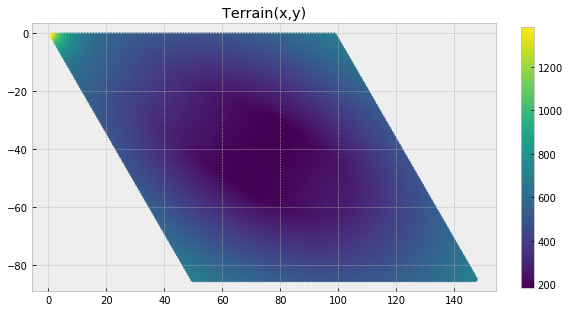

In [37]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111, aspect = 'equal')
points = ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.Q_a.flatten())
fig.colorbar(points,fraction=0.026)
ax.set_title('Terrain(x,y)')

Text(0.5,1,'soft sediment(x,y)')

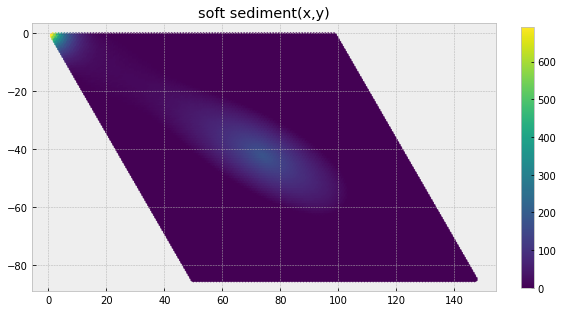

In [38]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111, aspect = 'equal')
points = ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.Q_d.flatten())
fig.colorbar(points,fraction=0.026)
ax.set_title('soft sediment(x,y)')

Text(0.5,1,'soft sediment(x,y)')

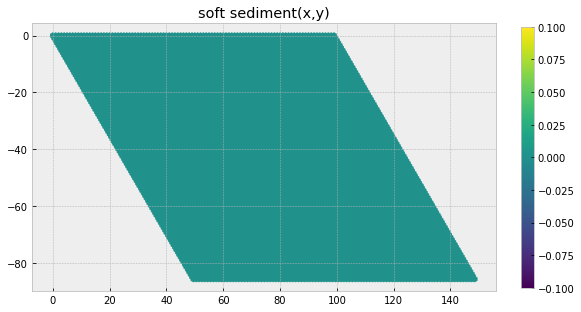

In [39]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111, aspect = 'equal')
points = ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.Q_v.flatten())
fig.colorbar(points,fraction=0.026)
ax.set_title('soft sediment(x,y)')